In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#other useful imports
import time
import numpy as np
import scipy as sp
import scipy.stats as stats
import h5py

In [3]:
#loading code modules containing some of the routines we wrote last time
#... so we don't have to write them again here! this is called "code reuse" :)

import metrics ; reload(metrics)
import cross_validation as cv; reload(cv)
from utils import featurewise_norm

In [4]:
#see, the "metrics" module has a bunch of functions computing performance metrics
#from confusion matrices (etc) that we defined yesterclass
print(dir(metrics))

#while the cross_validation module has the "get_splits" function
print(dir(cv))

#the "__X__" items are built-in standard stuff that all python modules have 
#(you can essentially ignore that stuff)

['__builtins__', '__doc__', '__file__', '__name__', '__package__', 'accuracy_confmat', 'balanced_accuracy', 'confusion_matrix_stats', 'dprime_binary', 'dprime_confmat', 'dprime_from_rates', 'evaluate_results', 'get_confusion_matrix', 'np', 'stats']
['GridSearchCV', '__builtins__', '__doc__', '__file__', '__name__', '__package__', 'featurewise_norm', 'get_splits', 'metrics', 'np', 'train_and_test_scikit_classifier', 'validate_splits']


In [5]:
#ok let's load our usual data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

In [6]:
Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

var_level = Ventral_Dataset['image_meta']['variation_level'][:]
categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 

objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}


In [7]:
#use numpy recarray object to store metadata 
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

meta_array.dtype

dtype((numpy.record, [(u'category', 'S7'), (u'image_id', 'S40'), (u'object_name', 'S24'), (u'rotation_xy', '<f8'), (u'rotation_xz', '<f8'), (u'rotation_yz', '<f8'), (u'size', '<f8'), (u'translation_y', '<f8'), (u'translation_z', '<f8'), (u'variation_level', 'S2')]))

## TwoD Projection of Binary Class

In [8]:
from sklearn.manifold import MDS
def plot_in_2d_projection(vl, cat1, cat2):
    subset_inds = (var_level == vl) & ((categories == cat1) | (categories == cat2))
    Neural_Data_subset = IT_Neural_Data[subset_inds]  
    category_subset = categories[subset_inds]
    
    #using the unsupervised "Multi-dimensional scaling" method (MDS)
    distmat = 1 - np.corrcoef(Neural_Data_subset)
    x, y = MDS(dissimilarity='precomputed').fit_transform(distmat).T

    xb = x[category_subset == cat1]
    yb = y[category_subset == cat1]
    xc = x[category_subset == cat2]
    yc = y[category_subset == cat2]
    plt.scatter(xb, yb, color='b')
    plt.scatter(xc, yc, color='r')
    plt.axis('equal')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')

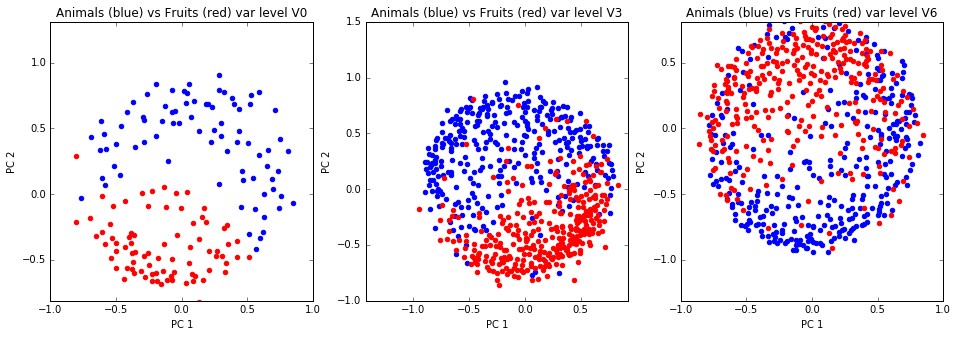

In [9]:
cat1 = 'Animals'
cat2 = 'Fruits'

fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plot_in_2d_projection('V0', cat1, cat2)
plt.title('%s (blue) vs %s (red) var level %s' % (cat1, cat2, 'V0'))

plt.subplot(1, 3, 2)
plot_in_2d_projection('V3', cat1, cat2)
plt.title('%s (blue) vs %s (red) var level %s' % (cat1, cat2, 'V3'))

plt.subplot(1, 3, 3)
plot_in_2d_projection('V6', cat1, cat2)
plt.title('%s (blue) vs %s (red) var level %s' % (cat1, cat2, 'V6'))



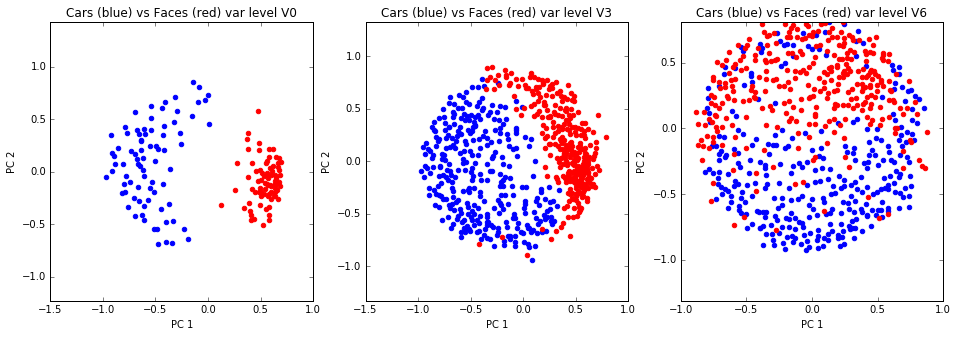

In [10]:
cat1 = 'Cars'
cat2 = 'Faces'

fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plot_in_2d_projection('V0', cat1, cat2)
plt.title('%s (blue) vs %s (red) var level %s' % (cat1, cat2, 'V0'))

plt.subplot(1, 3, 2)
plot_in_2d_projection('V3', cat1, cat2)
plt.title('%s (blue) vs %s (red) var level %s' % (cat1, cat2, 'V3'))

plt.subplot(1, 3, 3)
plot_in_2d_projection('V6', cat1, cat2)
plt.title('%s (blue) vs %s (red) var level %s' % (cat1, cat2, 'V6'))



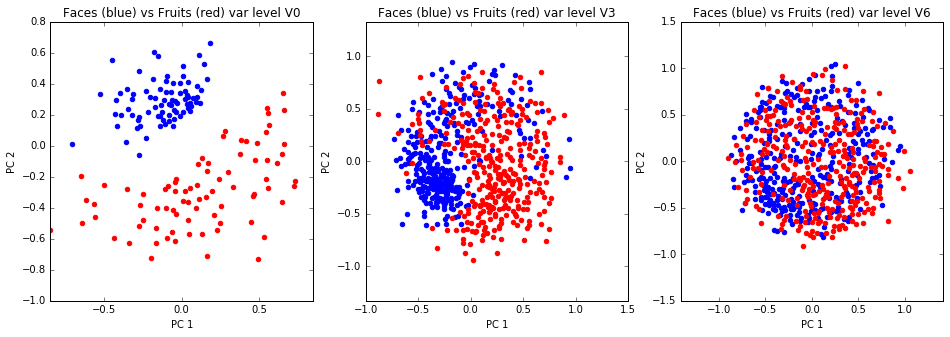

In [11]:
cat1 = 'Faces'
cat2 = 'Fruits'

fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plot_in_2d_projection('V0', cat1, cat2)
plt.title('%s (blue) vs %s (red) var level %s' % (cat1, cat2, 'V0'))

plt.subplot(1, 3, 2)
plot_in_2d_projection('V3', cat1, cat2)
plt.title('%s (blue) vs %s (red) var level %s' % (cat1, cat2, 'V3'))

plt.subplot(1, 3, 3)
plot_in_2d_projection('V6', cat1, cat2)
plt.title('%s (blue) vs %s (red) var level %s' % (cat1, cat2, 'V6'))



## Binary SVM

In [12]:
#ok, last time we developed train_and_test_correlation_classifier
#let's generalize that to using any scikit-learn based classifier
    
#we'll coming back to this one line below, later
from sklearn.model_selection import GridSearchCV

def train_and_test_scikit_classifier(features, 
                                     labels,
                                     splits,
                                     model_class,
                                     model_args=None,
                                     gridcv_params=None,                                     
                                     feature_norm=True,
                                     return_models=False
                                    ):
    """Routine for contructing, training and testing correlation classifier
       
       Arguments: 
           features: (K, M) feature array where K = number of stimuli and M = number of features
           labels: length-K vector of labels to be predicted
           splits: splits of data (constructed by calling the get_splits function)
           model_class: the actual live pythone object that is the classifier "class" object
           model_args: dictionary of arguments for instantiating the classifier class obejct
           gridcv_params: dictionary of params for applying gridSearch cross-validation to
           feature_norm: apply featurewise_norm
           return_models: return actual trained models for each split
           
       Returns:
           dictionary summary of training and testing results
    
    """
    train_confmats = []
    test_confmats = []
    
    if model_args is None:
        model_args = {}
    
    training_sidedata = []
    train_classes = cv.validate_splits(splits, labels)
    
    models = []
    
    for split in splits:

        #here we instantiate the general classifier, whatever it is    
        model = model_class(**model_args)
    
        if gridcv_params is not None:
            model = GridSearchCV(model, gridcv_params)

        train_inds = split['train']
        test_inds = split['test']
        train_features = features[train_inds]
        train_labels = labels[train_inds]
        test_features = features[test_inds]
        test_labels = labels[test_inds]

        if feature_norm:
            train_features, fmean, fvar = featurewise_norm(train_features)
            sidedata = {'fmean': fmean, 'fvar': fvar}
            training_sidedata.append(sidedata)
        
        model.fit(train_features, train_labels)
        classes_ = model.classes_
        assert set(model.classes_) == set(train_classes)
        sidedata['classes_'] = classes_
        
        train_predictions = model.predict(train_features)
        train_confmat = metrics.get_confusion_matrix(train_predictions, 
                                                     train_labels, 
                                                     train_classes)
        train_confmats.append(train_confmat)
                
        if feature_norm:
            test_features, _ignore, _ignore = featurewise_norm(test_features,
                                                               fmean=fmean,
                                                               fvar=fvar)
            
        test_predictions = model.predict(test_features)
        test_confmat = metrics.get_confusion_matrix(test_predictions, test_labels, train_classes)
        test_confmats.append(test_confmat)
        
        if return_models:
            models.append(model)
        
    train_confmats = np.array(train_confmats)
    train_results = metrics.evaluate_results(train_confmats, train_classes)
    test_confmats = np.array(test_confmats)
    test_results = metrics.evaluate_results(test_confmats, train_classes)
    results = {'train': train_results,
               'test': test_results,
               'training_sidedata': training_sidedata}
    if return_models:
            results['models'] = models
            
    return results, train_classes

In [13]:
#here's a function that wraps the whole procedure together
#including creating the splits and doing the training and testing
def scikit_learn_classifier_procedure(features, 
                                      meta_array,
                                      label_func,
                                      split_by_func,
                                      num_splits,
                                      num_per_class_test,
                                      num_per_class_train,
                                      model_class,
                                      model_args=None,
                                      train_filter=None,
                                      test_filter=None,
                                      feature_norm=True,
                                      return_models=False                           
                                    ):
    
    splits = cv.get_splits(metadata=meta_array,
                           split_by_func=split_by_func,
                           num_splits=num_splits,
                           num_per_class_test=num_per_class_test,
                           num_per_class_train=num_per_class_train,
                           train_filter=train_filter,
                           test_filter=test_filter
                          )
    
    if callable(label_func):
        labels = label_func(meta_array)
    else:
        labels = meta_array[label_func]
    
    return train_and_test_scikit_classifier(features=features, 
                                            labels=labels,
                                            splits=splits,
                                            model_class=model_class,
                                            model_args=model_args,
                                            feature_norm=feature_norm,
                                            return_models=return_models)


In [14]:
#now, let's actually import the Linear Support Vector Classifier (LinearSVC)
#from scikit
from sklearn.svm import LinearSVC

In [15]:
#... and let's import the minimum distance classifier from last time .. for comparison purposes
import minimum_distance_classifier as mdc

In [16]:
#Let's test our classifier -- first the old MinimumDistanceClassifier

cat1 = 'Animals'
cat2 = 'Fruits'

results_correlation_classifier = {}
for vl in ['V0', 'V3', 'V6']:
    splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        10,  
                        5,  
                        5 if vl == 'V0' else 35,  
                        train_filter=lambda x: (x['variation_level'] == vl) and (x['category'] in [cat1, cat2]),
                        test_filter=lambda x: (x['variation_level'] == vl) and (x['category'] in [cat1, cat2])
                       )

    results, train_classes = train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=mdc.MinimumDistanceClassifier
                                              )
    results_correlation_classifier[vl] = results
    print('Correlation Classifier Var level %s performance on %s vs %s: %.2f%%' % (vl,   
                                                                           cat1,
                                                                           cat2,
                                                                           100*results['test']['mean_accuracy']))

Correlation Classifier Var level V0 performance on Animals vs Fruits: 97.00%
Correlation Classifier Var level V3 performance on Animals vs Fruits: 88.00%
Correlation Classifier Var level V6 performance on Animals vs Fruits: 71.88%


In [17]:
#Now let's compare it to the LinearSVC
cat1 = 'Animals'
cat2 = 'Fruits'

results_svm = {}
for vl in ['V0', 'V3', 'V6']:
    splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        10,  
                        5,  
                        5 if vl == 'V0' else 35,  
                        train_filter=lambda x: (x['variation_level'] == vl) and (x['category'] in [cat1, cat2]),
                        test_filter=lambda x: (x['variation_level'] == vl) and (x['category'] in [cat1, cat2])
                       )

    results, train_classes = train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC
                                              )
    results_svm[vl] = results
    print('SVM Classifier Var level %s performance on %s vs %s: %.2f%%' % (vl,   
                                                                           cat1,
                                                                           cat2,
                                                                           100*results['test']['mean_accuracy']))
    
#ok we see some substantial improvements

SVM Classifier Var level V0 performance on Animals vs Fruits: 99.38%
SVM Classifier Var level V3 performance on Animals vs Fruits: 93.00%
SVM Classifier Var level V6 performance on Animals vs Fruits: 78.75%


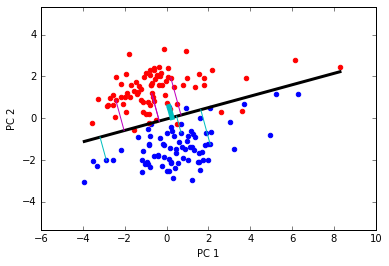

In [18]:
#let's actually see why this works 

from sklearn.decomposition import PCA
def plot_in_2d_projection_with_hyperplane_and_margins(vl, cat1, cat2, C=1, highlight_wrong=True):
    #subset the data properly for two target categories
    subset_inds1 = ((var_level == vl) & (categories == cat1)).nonzero()[0]
    subset_inds2 = ((var_level == vl) & (categories == cat2)).nonzero()[0]
    subset_inds = np.concatenate([subset_inds1, subset_inds2])
    Neural_Data_subset = IT_Neural_Data[subset_inds]  
    category_subset = categories[subset_inds]
    
    #let's push the data into two dimensions using PCA so we can see 
    #what's going on ... this is like what we did with the MDS before
    #except now it generalizations to other data points
    pca = PCA(n_components=2)
    x, y = pca.fit_transform(Neural_Data_subset).T
    xb = x[category_subset == cat1]
    yb = y[category_subset == cat1]
    xc = x[category_subset == cat2]
    yc = y[category_subset == cat2]
    plt.scatter(xb, yb, color='b')
    plt.scatter(xc, yc, color='r')
    plt.axis('equal')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    
    #ok let's fit an SVM on our 2-D data.
    model = LinearSVC(C=C)
    z = np.column_stack([x, y])
    model.fit(z, category_subset)
    #get the models' weights and intercept
    weights = model.coef_
    intercept = model.intercept_
    w0, w1 = weights[0]  #there are two components of the weight vector since we're working with 2-D features
    boundary_slope = -w0 / w1  #slope of the bounary line in terms of weights
    boundary_intercept = -intercept[0] / w1    #intercept

    #let's plot the hyperplane boundary (this is really just a line since we're in 2D)
    boundary_func = lambda _w: boundary_slope * _w + boundary_intercept
    boundary_func_inv = lambda _w: (_w - boundary_intercept) / boundary_slope
    _a = x.min(); _b = x.max()
    _c = y.min(); _d = y.max()
    if _b - _a < _d - _c:
        plt.plot([boundary_func_inv(_c), boundary_func_inv(_d)], 
             [_c, _d], color='k', linewidth=3)
    else:
        plt.plot([_a, _b], [boundary_func(_a), boundary_func(_b)],
                 color='k', linewidth=3)
    
    #ok let's get the margins of the classifier
    margins = model.decision_function(z)
    
    #our goal is to compare the margins to the distance of a point to the 
    #boundary line
    #to compare margins, we have to correct it with three factors
    #factor 1: the sign of the prediction
    preds = np.sign(margins)
    first_correct_red = preds[category_subset == cat2].nonzero()[0][0]
    xc0 = xc[first_correct_red]
    yc0 = yc[first_correct_red]
    prediction_sign = (2 * (boundary_func(xc0) > yc0) - 1) * np.sign(-boundary_slope)
    
    #factor 2: we have to scale by the root-mean-square of the model weights
    weight_norm = 1 / np.sqrt(np.sum(weights ** 2))
    #weight_norm = 1
    
    #factor 3: we have to go along x direction by an amount dx such that the distance traveled
    #along the line perpendicular to the boundary is given by the correct margin
    #which can be derived from the pythagorean theorem 
    distance_mult = (1 / np.sqrt(1 + 1./boundary_slope**2))

    #ok so here's the distance we travel in the x-direction as dictated
    #by the margins
    dx = margins * prediction_sign * weight_norm * distance_mult
    
    #increment the x positons by dx
    xp = z[:, 0] + dx 
    #increment the y positions by the proper amount along the perpendicular 
    #to the boundary line
    yp = z[:, 1] + (-1./boundary_slope) * dx 

    #now let's plot them
    how_many = len(category_subset)
    #make plot line thicker to data points that are wrong if desired .... 
    if highlight_wrong:
        actual = 2 * (category_subset == cat2) - 1
        wrong = preds != actual
        linewidth = 4 * wrong + 1
    else:
        linewidth = 2*np.ones(how_many)
    for k in range(0, how_many, 20):
        if category_subset[k] == cat1:
            plt.plot([z[k][0], xp[k]], [z[k][1], yp[k]], color='c', linewidth=linewidth[k])
        else:
            plt.plot([z[k][0], xp[k]], [z[k][1], yp[k]], color='m', linewidth=linewidth[k])
    


plot_in_2d_projection_with_hyperplane_and_margins('V0', 
                                                  'Animals', 
                                                  'Cars',
                                                   C=1)


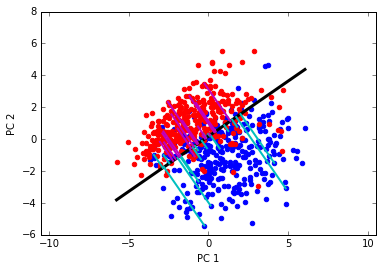

In [19]:
plot_in_2d_projection_with_hyperplane_and_margins('V3', 'Animals', 'Fruits', 
                                                  highlight_wrong=False)

## Multi-class classification via One-Vs-All

In [22]:
from sklearn.manifold import MDS
def plot_all_in_2d_projection(vl):
    subset_inds = (var_level == vl)
    Neural_Data_subset = IT_Neural_Data[subset_inds]  
    category_subset = categories[subset_inds]
    
    distmat = 1 - np.corrcoef(Neural_Data_subset)
    x, y = MDS(dissimilarity='precomputed').fit_transform(distmat).T

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    for color, cat in zip(colors, unique_categories):
        xcat = x[category_subset == cat]
        ycat = y[category_subset == cat]
        plt.scatter(xcat, ycat, color=color)
    plt.axis('equal')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')

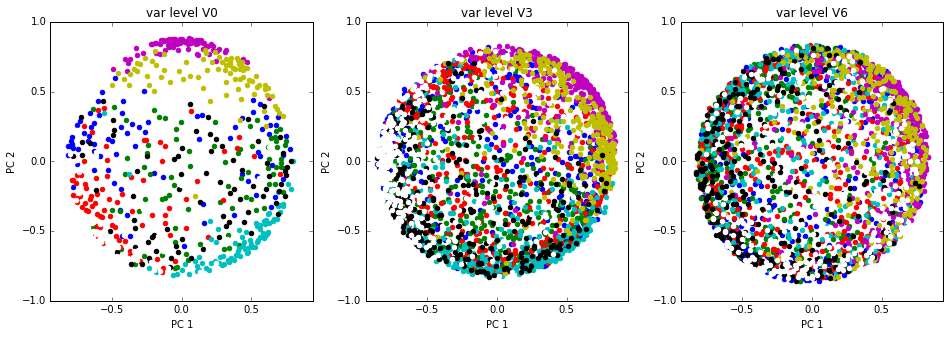

In [23]:
fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plot_all_in_2d_projection('V0')
plt.title('var level %s' % 'V0')

plt.subplot(1, 3, 2)
plot_all_in_2d_projection('V3')
plt.title('var level %s' % 'V3')

plt.subplot(1, 3, 3)
plot_all_in_2d_projection('V6')
plt.title('var level %s' % 'V6')



In [24]:
results_correlation_classifier_8way = {}
for vl in ['V0', 'V3', 'V6']:
    splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        10,  
                        5,  
                        5 if vl == 'V0' else 35,  
                        train_filter=lambda x: (x['variation_level'] == vl),
                        test_filter=lambda x: (x['variation_level'] == vl)
                       )

    results, train_classes = train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=mdc.MinimumDistanceClassifier
                                              )
    results_correlation_classifier_8way[vl] = results
    print('Correlation Classifier Var level %s performance 8-way: %.2f%%' % (vl,
                                                                           100*results['test']['mean_accuracy']))

Correlation Classifier Var level V0 performance 8-way: 83.19%
Correlation Classifier Var level V3 performance 8-way: 66.03%
Correlation Classifier Var level V6 performance 8-way: 43.19%


In [25]:
results_svm_classifier_8way = {}
for vl in ['V0', 'V3', 'V6']:
    splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        10,  
                        5,  
                        5 if vl == 'V0' else 35,  
                        train_filter=lambda x: (x['variation_level'] == vl),
                        test_filter=lambda x: (x['variation_level'] == vl)
                       )

    results, train_classes = train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC
                                              )
    results_svm_classifier_8way[vl] = results
    print('SVM Classifier Var level %s performance 8-way: %.2f%%' % (vl,
                                                                     100*results['test']['mean_accuracy']))

SVM Classifier Var level V0 performance 8-way: 91.69%
SVM Classifier Var level V3 performance 8-way: 77.75%
SVM Classifier Var level V6 performance 8-way: 54.69%


In [26]:
#Let's make sure we understand the one-vs-all decision rule

splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  #we're balancing splits by object
                        1, #we only need one split right now since we're looking at a single model 
                        5,  
                        35,  
                        train_filter=lambda x: (x['variation_level'] == 'V3'),
                        test_filter=lambda x: (x['variation_level'] == 'V3')
                       )

results, train_classes = train_and_test_scikit_classifier(features=Neural_Data, 
                                               labels=meta_array['category'],
                                               splits=splits,
                                               model_class=LinearSVC,
                                               return_models=True
                                              )

test_meta = meta_array['category'][splits[0]['test']]
trained_model = results['models'][0]

In [27]:
trained_model

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

('Weights shape:', (8, 296))


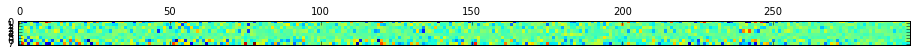

In [28]:
weights = trained_model.coef_
print('Weights shape:', weights.shape)
plt.matshow(weights)
#these 8 vectors come from training binary one-vs-all SVMs 
#on each for the 8 categories separately

In [29]:
bias = trained_model.intercept_
print('Bias shape:', bias.shape)
#the bias is simply an 8-vector, one value for each category

('Bias shape:', (8,))


In [30]:
#Let's apply the trained model to the test data
test_data = Neural_Data[splits[0]['test']]
print('Number of test stimuli: %d' % test_data.shape[0])
#recall, we have to do feature norm since that was done in the training
fmean = results['training_sidedata'][0]['fmean']
fvar = results['training_sidedata'][0]['fvar']
normed_test_data = featurewise_norm(test_data, fmean=fmean, fvar = fvar)[0]

Number of test stimuli: 320


In [31]:
#this is the core operation -- taking the matrix product of the data and weights
#and then adding the bias
hyperplane_output = np.dot(normed_test_data, weights.T) + bias
hyperplane_output.shape
#see, it produces output of shape (num_stimuli x num_classes)
#these outputs *should* be the margin of the classifier

(320, 8)

In [32]:
#now, here are the margins are returned by the decision_function
margins = trained_model.decision_function(normed_test_data)

#See, the shape is again (num_stimuli x num_categories)
margins.shape

(320, 8)

In [33]:
#let's look at a specific example
example_ind = 28

print(margins[example_ind])
print(hyperplane_output[example_ind])

#see, so the decision_function margins are the same as returned 
#by the basic hyperplanne formula

[  1.21868118  -4.63445006  -1.14574895  -5.56903986  -3.93557614
  -3.85784783  -6.63613811 -11.41076234]
[  1.21868118  -4.63445006  -1.14574895  -5.56903986  -3.93557614
  -3.85784783  -6.63613811 -11.41076234]


In [34]:
#now let's look at the relationship bewteen the margins and the final prediction

example_ind = 0

#the prediction comes from the most confidence category
highest_margin_category_index = margins[example_ind].argmax()

print('Prediction: category %d -- e.g. %s' % (highest_margin_category_index, 
                                              unique_categories[highest_margin_category_index]))

#what was the actual category for the instance?
print('Actual: %s' % test_meta[example_ind])


Prediction: category 5 -- e.g. Fruits
Actual: Fruits


In [35]:
margins.argmax(axis=1)

array([5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 4, 0, 1, 3, 0, 2, 2, 7, 0, 7, 0, 7, 0, 0, 3, 0, 5,
       6, 6, 1, 3, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 6, 1, 1, 5,
       5, 5, 5, 5, 0, 2, 2, 1, 0, 3, 1, 6, 6, 3, 3, 3, 3, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 6, 6, 6, 1, 6,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 5, 7, 7, 7, 7, 3, 7, 7,
       7, 7, 0, 6, 2, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 1, 7, 7, 6, 6, 6, 6,
       6, 7, 7, 0, 0, 7, 2, 7, 0, 7, 7, 1, 7, 4, 7, 7, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 0, 0, 0, 7, 7, 0, 6, 6, 7, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 7, 0, 0, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 1, 7, 6, 1, 1,
       6, 0, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3,
       4, 0, 0, 5, 0, 7, 7, 6, 6, 6, 5, 6, 3, 6, 2, 6, 1, 6, 1, 1, 1, 5,
       5, 5, 5, 6, 1, 0, 6, 6, 6, 0, 1, 6, 6, 6, 1,

In [36]:
unique_categories[margins.argmax(axis=1)]

array(['Fruits', 'Fruits', 'Fruits', 'Fruits', 'Fruits', 'Fruits',
       'Fruits', 'Fruits', 'Faces', 'Fruits', 'Boats', 'Boats', 'Boats',
       'Boats', 'Boats', 'Cars', 'Cars', 'Cars', 'Cars', 'Cars', 'Boats',
       'Boats', 'Boats', 'Boats', 'Boats', 'Boats', 'Boats', 'Faces',
       'Animals', 'Boats', 'Chairs', 'Animals', 'Cars', 'Cars', 'Tables',
       'Animals', 'Tables', 'Animals', 'Tables', 'Animals', 'Animals',
       'Chairs', 'Animals', 'Fruits', 'Planes', 'Planes', 'Boats',
       'Chairs', 'Boats', 'Boats', 'Fruits', 'Fruits', 'Fruits', 'Fruits',
       'Fruits', 'Fruits', 'Fruits', 'Fruits', 'Fruits', 'Fruits',
       'Boats', 'Boats', 'Planes', 'Boats', 'Boats', 'Fruits', 'Fruits',
       'Fruits', 'Fruits', 'Fruits', 'Animals', 'Cars', 'Cars', 'Boats',
       'Animals', 'Chairs', 'Boats', 'Planes', 'Planes', 'Chairs',
       'Chairs', 'Chairs', 'Chairs', 'Faces', 'Chairs', 'Chairs',
       'Chairs', 'Chairs', 'Chairs', 'Chairs', 'Chairs', 'Chairs',
       'Chairs',

In [37]:
#Let's check this out overall

#get the most confidence (highest margin) category for all test stimuli
pred = unique_categories[margins.argmax(axis=1)]

#What fraction of these agree? 
fraction = (pred == test_meta).sum() / 320.
print('percent pred==actual: %.2f%%' % (fraction * 100))

#ah this is the same as was measured in the formal evaluation abvoe
print('formal result: %.2f%%' % (100 * results['test']['mean_accuracy']))

#so the classifier IS doing the "maximum margin" rule

percent pred==actual: 80.62%
formal result: 80.62%


## Nearest Neighbor classifiers

In [38]:
splits = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  
                        5,  
                        5,  
                        75,  
                        train_filter=lambda x: (x['variation_level'] in ['V3', 'V6']),
                        test_filter=lambda x: (x['variation_level'] in ['V3', 'V6'])
                       )

In [39]:
t0 = time.time()
SVM_res = train_and_test_scikit_classifier(features=Neural_Data, 
                                 labels=meta_array['category'],
                                 splits=splits,
                                 model_class=LinearSVC,
                                 model_args={'C': 1e-3}
                                 )
t_SVM = time.time() - t0

In [40]:
t0 = time.time()
MDC_res = train_and_test_scikit_classifier(features=Neural_Data, 
                                 labels=meta_array['category'],
                                 splits=splits,
                                 model_class=mdc.MinimumDistanceClassifier
                                 )
t_MDC = time.time() - t0

In [41]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:
t0 = time.time()
KNN_res = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                 labels=meta_array['category'],
                                 splits=splits,
                                 model_class=KNeighborsClassifier,
                                 model_args={'n_neighbors': 5}
                                 )
t_KNN = time.time() - t0

In [43]:
print('SVM Accuracy: %.2f%%, Time: %fs' % (SVM_res[0]['test']['mean_accuracy']*100, t_SVM))
print('MDC Accuracy: %.2f%%, Time: %fs' % (MDC_res[0]['test']['mean_accuracy']*100, t_MDC))
print('KNN Accuracy: %.2f%%, Time: %fs' % (KNN_res[0]['test']['mean_accuracy']*100, t_KNN))
#chance here is an 12.5%

SVM Accuracy: 73.50%, Time: 2.815814s
MDC Accuracy: 52.81%, Time: 0.139540s
KNN Accuracy: 52.44%, Time: 52.628322s


## Logistic Regression

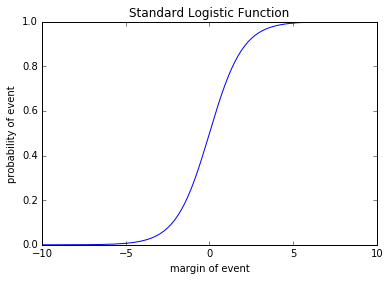

In [44]:
#Let's have a look at the output of the logistic function
def standard_logistic(x):
    return 1. / (1 + np.exp(-x))

x = np.arange(-10, 10, .1)
y = standard_logistic(x)
plt.plot(x, y)
plt.xlabel('margin of event')
plt.ylabel('probability of event')
plt.title('Standard Logistic Function')

In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
#this uses the one-vs-all strategy to handle multiclass logistic regression
t0 = time.time()
LR_res = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                 labels=meta_array['category'],
                                 splits=splits,
                                 model_class=LogisticRegression,
                                 model_args={'solver': 'saga',
                                            'C': 1e-2}
                                 )
t_LR = time.time() - t0

In [47]:
print('LR Accuracy: %.2f%%, Time: %fs' % (LR_res[0]['test']['mean_accuracy']*100, t_LR))


LR Accuracy: 73.75%, Time: 37.343122s


### Logistic Regression with Softmax multiclass

In [48]:
#this uses the softmax strategy to handle multiclass logistic regression
t0 = time.time()
LRmult_res = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                 labels=meta_array['category'],
                                 splits=splits,
                                 model_class=LogisticRegression,
                                 model_args={'solver': 'saga',
                                            'C': 1e-2, 
                                            'multi_class': 'multinomial'}
                                 )
t_LRmult = time.time() - t0

In [49]:
print('Multinomial LR Accuracy: %.2f%%, Time: %fs' % (LRmult_res[0]['test']['mean_accuracy']*100,
                                                      t_LRmult))


Multinomial LR Accuracy: 73.19%, Time: 23.026644s


In [50]:
#lets investigate a little more closely and actualyl look at one trained 
#logistic regression model
splits_1 = cv.get_splits(meta_array, 
                        lambda x: x['object_name'],  
                        1,  
                        5,  
                        75,  
                        train_filter=lambda x: (x['variation_level'] in ['V3', 'V6']),
                        test_filter=lambda x: (x['variation_level'] in ['V3', 'V6'])
                       )

LR_res_1 = cv.train_and_test_scikit_classifier(features=Neural_Data, 
                                 labels=meta_array['category'],
                                 splits=splits_1,
                                 model_class=LogisticRegression,
                                 model_args={'solver': 'saga',
                                             'multi_class': 'multinomial',
                                            'C': 1e-2},
                                 return_models=True
                                 )

model = LR_res_1[0]['models'][0]

model_weights = model.coef_
model_intercept = model.intercept_

In [51]:
test_data = Neural_Data[splits_1[0]['test']]
print('Number of test stimuli: %d' % test_data.shape[0])
#recall, we have to do feature norm since that was done in the training
fmean = LR_res_1[0]['training_sidedata'][0]['fmean']
fvar = LR_res_1[0]['training_sidedata'][0]['fvar']
normed_test_data = featurewise_norm(test_data, fmean=fmean, fvar = fvar)[0]

test_hyperplane = np.dot(normed_test_data, model.coef_.T) + model_intercept

test_margins = model.decision_function(normed_test_data)

test_probabilities = model.predict_proba(normed_test_data)

Number of test stimuli: 320


In [52]:
example_ind = 0
print(test_hyperplane[example_ind])
print(test_margins[example_ind])

#ok, so the decision function is outputting the same as for the SVM
#e.g. the output of "w * x + b", the distance of the point to the classifier hyperplane

[ 1.41979342 -3.23627529 -2.71198487 -0.72048149  1.85401766  7.33883073
 -2.99974193 -0.94415823]
[ 1.41979342 -3.23627529 -2.71198487 -0.72048149  1.85401766  7.33883073
 -2.99974193 -0.94415823]


In [53]:
#but what's the relationship between the decision function and the predicted probabilities?
def softmax(x):
    exp_vector = np.exp(x)
    exp_vector_sum = exp_vector.sum()
    return exp_vector / exp_vector_sum

example_ind = 0
print(softmax(test_margins[example_ind]))
print(test_probabilities[example_ind])

#ah, ok, so the probabilities are exactly the result of the softmax function applied
#to the classifier margins 
#of course, note that the estimated probability of the correct class 
#(in the case, the 5th class) is the highest -- > 99.2%

[2.66775936e-03 2.53537208e-05 4.28290204e-05 3.13788531e-04
 4.11839351e-03 9.92548859e-01 3.21193565e-05 2.50897016e-04]
[2.66775936e-03 2.53537208e-05 4.28290204e-05 3.13788531e-04
 4.11839351e-03 9.92548859e-01 3.21193565e-05 2.50897016e-04]
